# Value at Risk and Portfolio Theory

In [1]:
import numpy as np # to use arrays instead of lists
import pandas as pd # using values, shift, and pct_change

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# warnings and ignore for ease of reading notebook
import warnings
warnings.filterwarnings("ignore")

# quadratic optimizer
import scipy.stats as st
from scipy.optimize import minimize

In [2]:
# for development phase of module build allowing use of changes as they are made
# load autoreload extension
%load_ext autoreload 
# set to mode 2 
%autoreload 2 

In [4]:
import edhec_risk_kit as erk # import module of defined financial calculations

In [5]:
#from EDHEC import edhec_risk_kit as erk 

# Hedge Fund Indices
* UDHEC Hedge Fund Indices data set
* Analysis based on data since 2000, including 2000
* [Source](https://climateimpact.edhec.edu/all-downloads-hedge-funds-indices)

### Load and Process

In [6]:
hf = erk.get_hfi_returns()
hf = hf['2000':]
hf.head()

,Convertible Arbitrage,CTA Global,Distressed Securities,Emerging Markets,Equity Market Neutral,Event Driven,Fixed Income Arbitrage,Global Macro,Long/Short Equity,Merger Arbitrage,Relative Value,Short Selling,Funds Of Funds
date,,,,,,,,,,,,,
2000-01,0.0227,0.0128,0.0088,0.0077,0.0075,0.0088,0.0041,0.0021,0.0075,0.0143,0.0173,0.0427,0.0169
2000-02,0.0267,-0.0022,0.0421,0.0528,0.0253,0.0346,0.0097,0.0408,0.0699,0.0239,0.0185,-0.1340,0.0666
2000-03,0.0243,-0.0138,0.0103,0.0318,0.0134,0.0069,-0.0061,-0.0104,0.0006,0.0131,0.0163,-0.0230,0.0039
2000-04,0.0223,-0.0241,-0.0101,-0.0541,0.0168,-0.0059,-0.0006,-0.0304,-0.0201,0.0188,0.0092,0.1028,-0.0269
2000-05,0.0149,0.0114,-0.0132,-0.0433,0.0062,-0.0034,0.0107,-0.0070,-0.0097,0.0146,0.0080,0.0704,-0.0122


In [7]:
hf.index # check index as desired

PeriodIndex(['2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06',
             '2000-07', '2000-08', '2000-09', '2000-10',
             ...
             '2018-02', '2018-03', '2018-04', '2018-05', '2018-06', '2018-07',
             '2018-08', '2018-09', '2018-10', '2018-11'],
            dtype='period[M]', name='date', length=227)

### Distressed Securities Return Distribution

In [8]:
print(hf['Distressed Securities'].mean())
print(hf['Distressed Securities'].std())

0.006633480176211454
0.016398138998482217


<Axes: xlabel='Distressed Securities', ylabel='Count'>

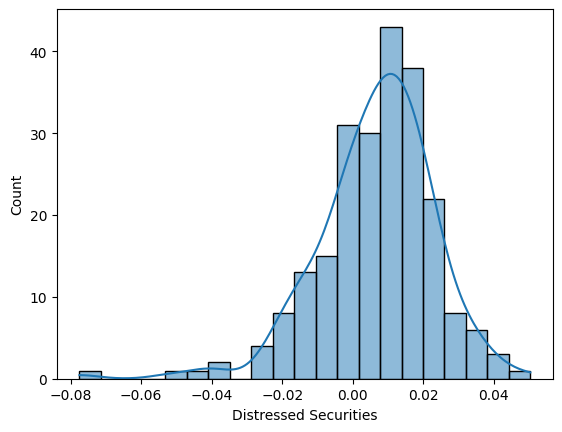

In [9]:
sns.histplot(hf['Distressed Securities'], kde=True)

In [10]:
erk.is_normal(r=hf['Distressed Securities'])

False

In [11]:
erk.skewness(r=hf['Distressed Securities'])

-0.9749778717005585

In [12]:
erk.kurtosis(r=hf['Distressed Securities'])

6.231719704616385

In [13]:
erk.kurtosis(r=hf['Distressed Securities']) - 3 # excess kurtosis

3.231719704616385

Returns for Distressed Securities are not normally distributed, there is a negative skew and a kurtosis greater than 3, thus we have a 'fat tail' in which crashes and upside swings occur more frequently than if the return distribution were Gaussian

### Monthly Parametric Gaussian VaR at 1% level of Distressed Securities

* assumption about the return distribution, a parametric assumption, of a Gaussian distribution
* this assumption can lead to underestimation of value at risk

In [14]:
erk.var_gaussian(r=hf['Distressed Securities'], level=1).round(4) 

0.0314

3.14% 
* level of 1%, worst 1% cutoff, using the z-score of this percent, as st.norm.ppf(0.01)
* for Distressed Securities there is a 1% chance that in any given month you will loose 3.14% 

### Monthly Cornish-Fisher Adjustment VaR at 1% level of Distressed Securities

* semi-parametric approach that does not force assumption of any particular return distribution
* correction for skewness and kurtosis of return distribution

In [15]:
erk.var_cornish_fisher(r=hf['Distressed Securities'], level=1).round(4)

0.0497

4.97%
* for Distressed Securities there is a 1% chance that in any given month you will loose 4.97%

### Monthly Historic VaR at 1% level of Distressed Securities

* no assumption about asset return distribution, not specifying a model
* solely looking at percent of worse outcomes
* solely relying on historic data
* sensitive to sample period, fair amount of sample risk

In [74]:
erk.var_historic(r=hf['Distressed Securities'], level=1).round(4)

0.0426

4.26%
* for Distressed Securities there is a 1% chance that in any given month you will loose 4.26%

# 30 Industry Returns
* During the 5 year period 2013 to 2017 inclusive
* [Source](https://climateimpact.edhec.edu/all-downloads-hedge-funds-indices)

### Load and Process

In [37]:
ind = erk.get_ind_returns()
ind.head()


,Food,Beer,Smoke,Games,Books,Hshld,Clths,Hlth,Chems,Txtls,...,Telcm,Servs,BusEq,Paper,Trans,Whlsl,Rtail,Meals,Fin,Other
1926-07,0.0056,-0.0519,0.0129,0.0293,0.1097,-0.0048,0.0808,0.0177,0.0814,0.0039,...,0.0083,0.0922,0.0206,0.0770,0.0193,-0.2379,0.0007,0.0187,0.0037,0.0520
1926-08,0.0259,0.2703,0.0650,0.0055,0.1001,-0.0358,-0.0251,0.0425,0.0550,0.0814,...,0.0217,0.0202,0.0439,-0.0238,0.0488,0.0539,-0.0075,-0.0013,0.0446,0.0676
1926-09,0.0116,0.0402,0.0126,0.0658,-0.0099,0.0073,-0.0051,0.0069,0.0533,0.0231,...,0.0241,0.0225,0.0019,-0.0554,0.0005,-0.0787,0.0025,-0.0056,-0.0123,-0.0386
1926-10,-0.0306,-0.0331,0.0106,-0.0476,0.0947,-0.0468,0.0012,-0.0057,-0.0476,0.0100,...,-0.0011,-0.0200,-0.0109,-0.0508,-0.0264,-0.1538,-0.0220,-0.0411,-0.0516,-0.0849
1926-11,0.0635,0.0729,0.0455,0.0166,-0.0580,-0.0054,0.0187,0.0542,0.0520,0.0311,...,0.0163,0.0377,0.0364,0.0384,0.0160,0.0467,0.0652,0.0433,0.0224,0.0400


In [38]:
ind.index

PeriodIndex(['1926-07', '1926-08', '1926-09', '1926-10', '1926-11', '1926-12',
             '1927-01', '1927-02', '1927-03', '1927-04',
             ...
             '2018-03', '2018-04', '2018-05', '2018-06', '2018-07', '2018-08',
             '2018-09', '2018-10', '2018-11', '2018-12'],
            dtype='period[M]', length=1110)

### Industry Choices: Portfolio of Four Assets


In [39]:
l = ['Books', 'Steel', 'Oil', 'Mines']

### Industry Portfolio Expected Returns
* here, looking at historic
* returns for a year of monthly returns

In [43]:
er = erk.annualize_rets(ind['2013':'2017'], 12)

In [44]:
er[l] # expected returns

Books    0.095312
Steel    0.100716
Oil      0.025275
Mines    0.005136
dtype: float64

<Axes: >

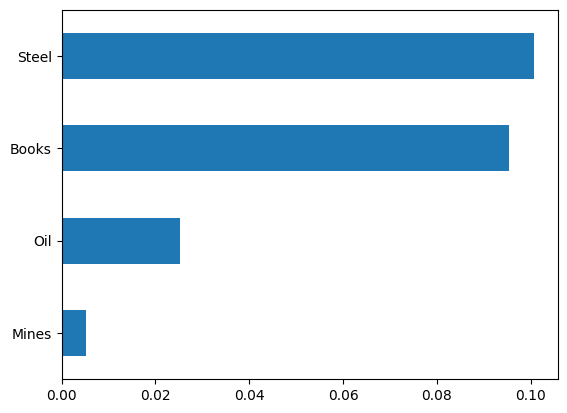

In [45]:
er[l].sort_values().plot(kind='barh')

### Industry Portfolio Covariance Matrix
* symmetric matrix with variances along diagonal and the product of the pairwise correlation and the individual volatilities (covariances) on the off-diagonal entries

In [46]:
cov = ind['2013':'2017'].cov()

<Axes: >

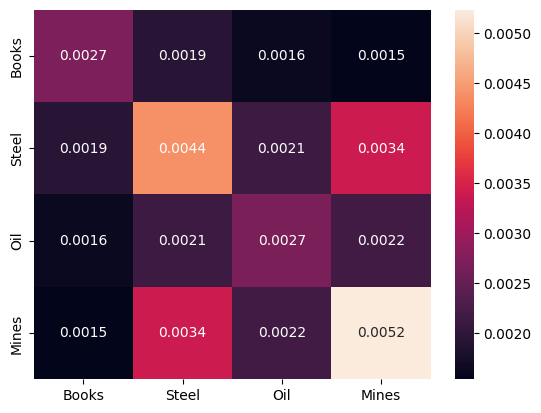

In [47]:
sns.heatmap(cov.loc[l,l], annot=True, fmt='.4f')

### MSR, EW, and GMV Portfolios for Books, Steel, Oil, and Mines Industries
* assuming the risk-free rate over the 5 year period is 10%

### EW (Equally-Weighted) Portfolio
* EW is not subject to any estimation error and as a result will likely have a higher risk-adjusted performance compared to the MSR portfolio based on sample estimates


In [49]:
# weight of assets an EW portfolio
n = er[l].shape[0]
w_ew = np.repeat(1/n, n)
w_ew

array([0.25, 0.25, 0.25, 0.25])

<Axes: xlabel='Volatility'>

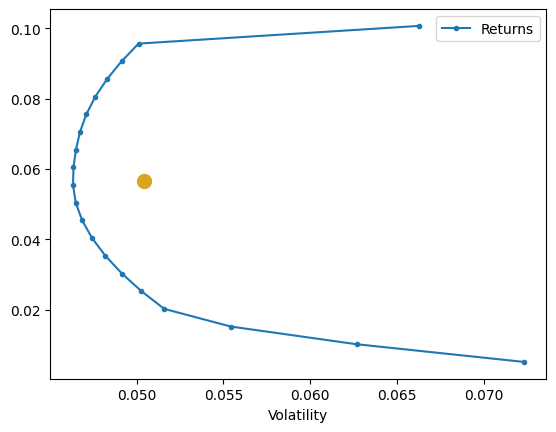

In [58]:
erk.plot_ef(20, er[l], cov.loc[l,l], show_ew=True, riskfree_rate=0.1) # risk-free rate no influence

each asset is equally-weighted, 25.0% in each industry

### Maximum Sharpe Ratio (MSR) Portfolio
* optimally choosing to hold a combination of that maximum Sharpe ratio portfolio and the risk-free asset
* highest return per unit risk
* where the capital market line (cml) intersects the efficient frontier, risk-free rate to efficient frontier
* maximizing slope of tangency line ~ increase return per unit risk
* no exposure to specific risks, only systematic risk
* pitfall: lack of robustness of Markowitz Analysis with respect to errors in parameter estimates, estimated returns estimates, the asset that suffers from the largest amount of estimation risk will get the largest allocation

In [51]:
l # assets

['Books', 'Steel', 'Oil', 'Mines']

In [56]:
rf = 0.1
w_msr = erk.msr(riskfree_rate=rf, er=er[l], cov=cov.loc[l,l]) # weights of msr
w_msr

array([0.00000000e+00, 1.00000000e+00, 6.00214323e-16, 7.35522754e-16])

put nearly 100% into steel, 1 asset having non-zero weight value

<Axes: xlabel='Volatility'>

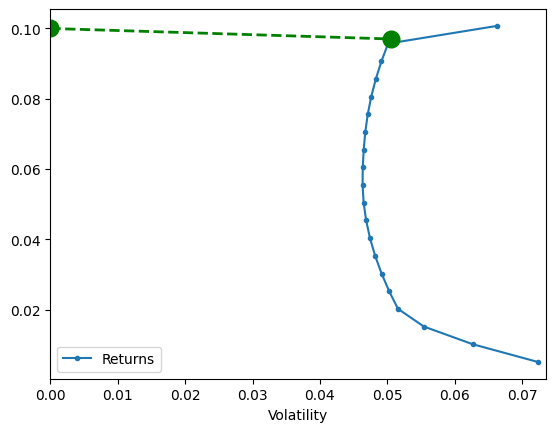

In [57]:
erk.plot_ef(20, er[l], cov.loc[l,l], show_cml=True, riskfree_rate=0.1)

### Global Minimum Variance (GMV) Portfolio
* minimize variance without any expected return targets
* portfolio on the efficient frontier is the least sensitive to estimation errors

In [61]:
l # assets

['Books', 'Steel', 'Oil', 'Mines']

In [60]:
w_gmv = erk.gmv(cov.loc[l,l])       
w_gmv

array([4.77024865e-01, 4.33680869e-19, 4.34112030e-01, 8.88631048e-02])

put 47.7% into Books, and with 43.4% in Oil, and with 8.9% in Mines, thus there are 3 assets with non-zero weights

<Axes: xlabel='Volatility'>

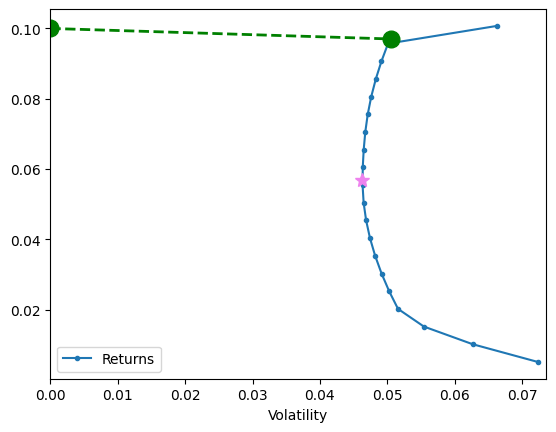

In [62]:
erk.plot_ef(20, er[l], cov.loc[l,l], show_cml=True, riskfree_rate=0.1, show_gmv=True)

### 12 Month Investment in 2018: GMV and MSR Portfolios

### Volatility of GMV and MSR

In [86]:
twocov = ind['2018':][l].cov()
twoer = erk.annualize_rets(r=ind['2018':][l], periods_per_year=12)

In [112]:
# GMV
w_gmv = erk.gmv(twocov)
vol_gmv = erk.portfolio_vol(weights=w_gmv, covmat=twocov)
vol_gmv

0.044078476848842876

In [117]:
r_gmv = erk.portfolio_return(weights=w_gmv, returns=twoer)
r_gmv*np.sqrt(12)*(-1) # annualized

1.0146680254314124

In [114]:
# MSR
w_msr = erk.msr(riskfree_rate=0.1, er=twoer, cov=twocov)
vol_msr = erk.portfolio_vol(weights=w_msr, covmat=twocov)
vol_msr

0.07277289497075275

In [118]:
r_msr = erk.portfolio_return(weights=w_msr, returns=twoer)
r_msr*np.sqrt(12)*(-1) # annualized

0.6282955773484961

<Axes: >

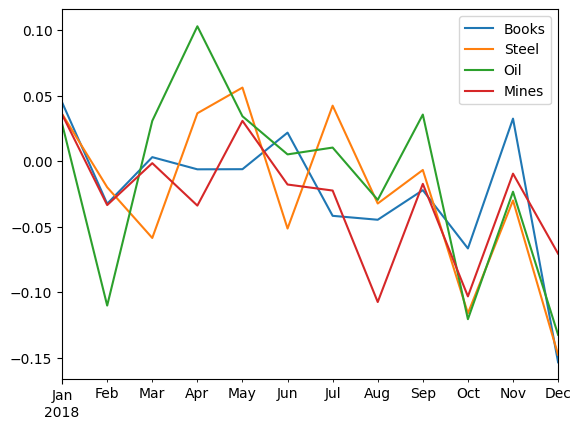

In [122]:
ind['2018':][l].plot(kind='line')